* **NO DATA CLEANING**
* **NO DATA IMPUTATION**
* **NO FEATURE SELECTION**
* **NO GRID SEARCH**

In [ ]:
!pip install lazypredict-nightly

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

In [ ]:
import time
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [ ]:
import lazypredict
from lazypredict import LazyRegressor

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import (
    LinearRegression, Lars, LassoLarsIC, Lasso, ElasticNet, LassoCV, LarsCV,
    LassoLarsCV, ElasticNetCV, BayesianRidge, HuberRegressor, PassiveAggressiveRegressor,
    Ridge, RidgeCV, SGDRegressor, TweedieRegressor, GammaRegressor, PoissonRegressor
)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import (
    GradientBoostingRegressor, BaggingRegressor, RandomForestRegressor,
    ExtraTreesRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
)
from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


## Preprocessing and feature engineering of the collected data

In [ ]:
# Load data
!wget https://raw.githubusercontent.com/cpariona/biomedical-thesis/refs/heads/main/data/docking_results/docking_scores_data.csv
!wget https://raw.githubusercontent.com/cpariona/biomedical-thesis/refs/heads/main/data/descriptors_data/RDKit_descriptors.csv

--2024-12-29 06:44:28--  https://raw.githubusercontent.com/cpariona/biomedical-thesis/refs/heads/main/data/docking_results/docking_scores_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338231 (330K) [text/plain]
Saving to: ‘docking_scores_data.csv’

docking_scores_data 100%[===================>] 330.30K  --.-KB/s    in 0.04s   

2024-12-29 06:44:28 (8.06 MB/s) - ‘docking_scores_data.csv’ saved [338231/338231]

--2024-12-29 06:44:28--  https://raw.githubusercontent.com/cpariona/biomedical-thesis/refs/heads/main/data/descriptors_data/RDKit_descriptors.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.

In [ ]:
df = pd.read_csv("docking_scores_data.csv")
df.columns

Index(['smiles', 'Delta_Gibbs'], dtype='object')

In [ ]:
# Handling missing data && cleaning
df = df.dropna(subset=['Delta_Gibbs'])
df = df.drop_duplicates(['smiles']).reset_index(drop=True)
df.shape

(8515, 2)

In [ ]:
# Load RDKit descriptors
RDKit_df = pd.read_csv("RDKit_descriptors.csv")
RDKit_df.shape

(8515, 210)

In [ ]:
# Load PaDEL descriptors
PaDEL_df = pd.read_csv("PaDEL_descriptors.csv")
PaDEL_df.shape

(8515, 1444)

### Exploratory Data Analysis (EDA)

**Frequency plot of Delta Gibbs**

Text(0, 0.5, 'Frequency')

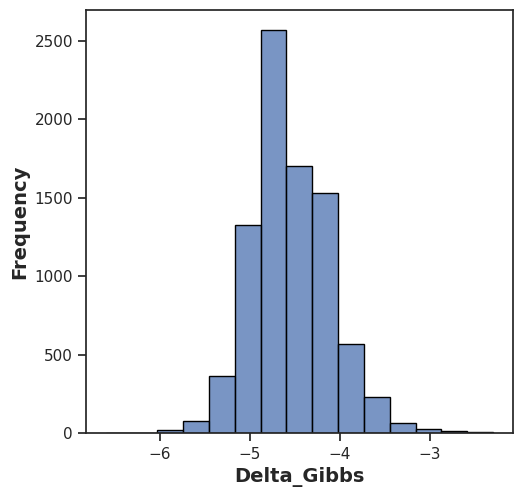

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.histplot(x='Delta_Gibbs', data=df, bins=15, edgecolor='black')

plt.xlabel('Delta_Gibbs', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

# plt.savefig('plot_bioactivity_class.pdf')

**Delta Gibbs Box plot**


Text(0, 0.5, 'Delta_Gibbs')

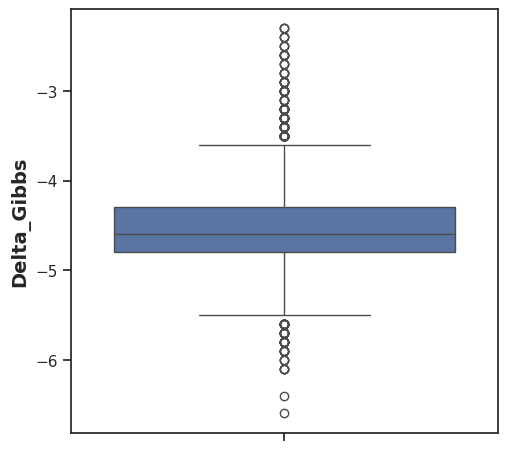

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(y='Delta_Gibbs', data=df)

plt.ylabel('Delta_Gibbs', fontsize=14, fontweight='bold')

**Descriptors Box Plot**

<Axes: >

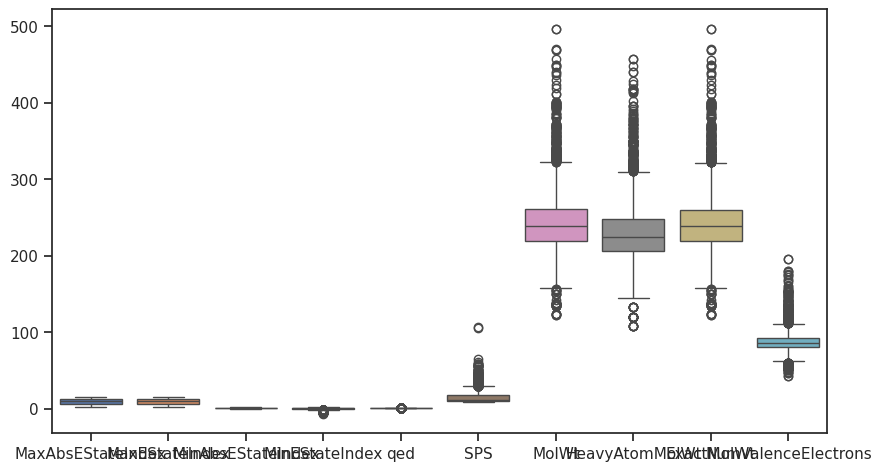

In [ ]:
# RDKit
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=RDKit_df.iloc[:,:10])

<Axes: >

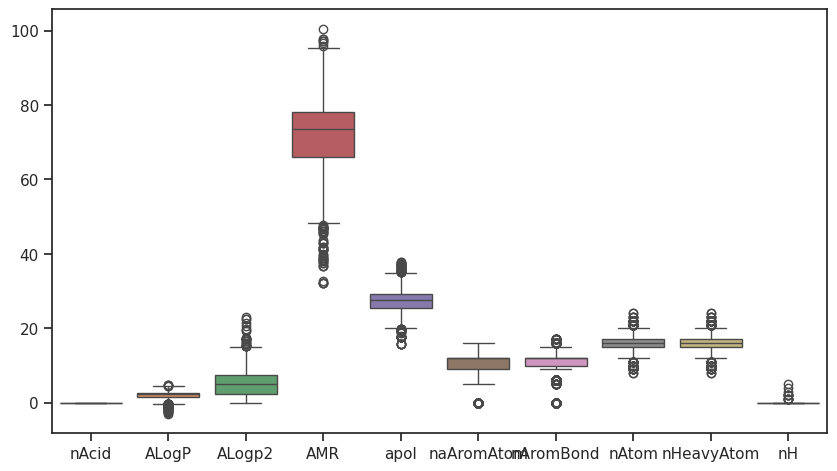

In [ ]:
# PaDEL
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=PaDEL_df.iloc[:,:10])

### Data Cleaning

RDKit

In [ ]:
RDKit_df.shape

(8515, 210)

In [ ]:
# Drop columns with NaN
RDKit_df = RDKit_df.dropna(axis='columns')
RDKit_df.shape

(8515, 210)

PaDEL

In [ ]:
PaDEL_df.shape

(8515, 1444)

In [ ]:
# Drop columns with NaN
PaDEL_df = PaDEL_df.dropna(axis='columns')
PaDEL_df.shape

(8515, 1377)

### Data Transformation

In [ ]:
# Initialization of data scalers
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

In [ ]:
# Scale data
RDKit_scaled = robust_scaler.fit_transform(RDKit_df)
RDKit_scaled = minmax_scaler.fit_transform(RDKit_scaled)
PaDEL_scaled = robust_scaler.fit_transform(PaDEL_df)
PaDEL_scaled = minmax_scaler.fit_transform(PaDEL_scaled)

In [ ]:
# Create RDKit scaled DataFrame
RDKit_columns = RDKit_df.columns
RDKit_scaled_df = pd.DataFrame(RDKit_scaled)
RDKit_scaled_df.columns = RDKit_columns
RDKit_scaled_df.describe()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,...,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00
mean,0.50,0.50,0.32,0.81,0.66,0.07,0.32,0.35,0.32,0.28,...,0.03,0.01,0.00,0.01,0.00,0.01,0.00,0.03,0.00,0.00
std,0.28,0.28,0.24,0.15,0.13,0.07,0.09,0.10,0.09,0.08,...,0.08,0.09,0.06,0.08,0.01,0.11,0.02,0.10,0.02,0.02
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.27,0.27,0.12,0.77,0.57,0.02,0.26,0.28,0.26,0.25,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.63,0.63,0.25,0.83,0.68,0.03,0.31,0.33,0.31,0.29,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.76,0.76,0.49,0.91,0.75,0.10,0.37,0.40,0.37,0.32,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [ ]:
# Create PaDEL scaled DataFrame
PaDEL_columns = PaDEL_df.columns
PaDEL_scaled_df = pd.DataFrame(PaDEL_scaled)
PaDEL_scaled_df.columns = PaDEL_columns
PaDEL_scaled_df.describe()

,nAcid,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,nB,nC,nN,...,MW,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,Zagreb
count,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,...,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00
mean,0.00,0.31,0.42,0.42,0.31,0.31,0.00,0.00,0.45,0.06,...,0.34,0.20,0.32,0.31,0.27,0.09,0.06,0.12,0.26,0.28
std,0.01,0.08,0.14,0.14,0.08,0.08,0.03,0.00,0.08,0.09,...,0.10,0.08,0.08,0.07,0.17,0.10,0.10,0.06,0.09,0.09
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.27,0.25,0.25,0.29,0.29,0.00,0.00,0.40,0.00,...,0.28,0.15,0.29,0.27,0.12,0.00,0.00,0.09,0.21,0.22
50%,0.00,0.31,0.50,0.50,0.32,0.32,0.00,0.00,0.44,0.00,...,0.33,0.19,0.33,0.30,0.23,0.09,0.00,0.11,0.26,0.26
75%,0.00,0.35,0.50,0.50,0.36,0.36,0.00,0.00,0.48,0.14,...,0.40,0.23,0.37,0.34,0.36,0.12,0.14,0.14,0.31,0.32
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### Merge descriptors dataframes with Delta Gibbs scores

In [ ]:
RDKit = pd.concat([RDKit_scaled_df,df['Delta_Gibbs']], axis = 1)
RDKit

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Delta_Gibbs
0,0.77,0.77,0.28,0.40,0.82,0.07,0.41,0.44,0.41,0.38,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-4.20
1,0.72,0.72,0.21,0.40,0.76,0.03,0.32,0.35,0.32,0.23,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-4.20
2,0.76,0.76,0.24,0.39,0.89,0.03,0.42,0.44,0.42,0.39,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-4.20
3,0.67,0.67,0.03,0.76,0.61,0.02,0.29,0.32,0.29,0.29,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-4.50
4,0.76,0.76,0.13,0.37,0.95,0.06,0.41,0.45,0.41,0.36,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-4.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8510,0.59,0.59,0.01,0.82,0.96,0.04,0.48,0.51,0.48,0.47,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-4.90
8511,0.57,0.57,0.11,0.84,0.88,0.02,0.44,0.46,0.44,0.44,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-4.70
8512,0.63,0.63,0.01,0.82,0.76,0.03,0.48,0.51,0.48,0.47,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-4.70
8513,0.62,0.62,0.03,0.82,0.70,0.04,0.40,0.43,0.40,0.39,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-5.10


In [ ]:
PaDEL = pd.concat([PaDEL_scaled_df,df['Delta_Gibbs']], axis = 1)
PaDEL

,nAcid,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,nB,nC,nN,...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,Zagreb,Delta_Gibbs
0,0.00,0.38,0.42,0.46,0.39,0.39,0.00,0.00,0.44,0.29,...,0.20,0.40,0.27,0.54,0.18,0.29,0.14,0.45,0.42,-4.20
1,0.00,0.25,0.42,0.46,0.25,0.25,0.00,0.00,0.32,0.00,...,0.27,0.26,0.27,0.40,0.18,0.00,0.07,0.29,0.24,-4.20
2,0.00,0.38,0.42,0.46,0.39,0.39,0.00,0.00,0.44,0.29,...,0.20,0.40,0.20,0.53,0.18,0.29,0.14,0.45,0.38,-4.20
3,0.00,0.24,0.42,0.46,0.32,0.32,0.00,0.00,0.36,0.29,...,0.17,0.33,0.26,0.49,0.27,0.29,0.11,0.32,0.29,-4.50
4,0.00,0.35,0.42,0.46,0.39,0.39,0.00,0.00,0.40,0.29,...,0.21,0.41,0.34,0.63,0.28,0.29,0.13,0.48,0.43,-4.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8510,0.00,0.44,0.50,0.50,0.50,0.50,0.00,0.00,0.56,0.00,...,0.17,0.53,0.36,0.51,0.51,0.00,0.24,0.50,0.49,-4.90
8511,0.00,0.42,0.50,0.50,0.46,0.46,0.00,0.00,0.56,0.00,...,0.16,0.48,0.26,0.41,0.41,0.00,0.23,0.40,0.39,-4.70
8512,0.00,0.44,0.50,0.50,0.50,0.50,0.00,0.00,0.56,0.00,...,0.17,0.53,0.34,0.52,0.52,0.00,0.21,0.63,0.50,-4.70
8513,0.00,0.38,0.50,0.50,0.43,0.43,0.00,0.00,0.52,0.00,...,0.16,0.45,0.37,0.41,0.41,0.00,0.16,0.53,0.43,-5.10


In [ ]:
RDKit_PaDEL = pd.concat([RDKit_scaled_df,PaDEL_scaled_df,df['Delta_Gibbs']], axis = 1)
RDKit_PaDEL

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,Zagreb,Delta_Gibbs
0,0.77,0.77,0.28,0.40,0.82,0.07,0.41,0.44,0.41,0.38,...,0.20,0.40,0.27,0.54,0.18,0.29,0.14,0.45,0.42,-4.20
1,0.72,0.72,0.21,0.40,0.76,0.03,0.32,0.35,0.32,0.23,...,0.27,0.26,0.27,0.40,0.18,0.00,0.07,0.29,0.24,-4.20
2,0.76,0.76,0.24,0.39,0.89,0.03,0.42,0.44,0.42,0.39,...,0.20,0.40,0.20,0.53,0.18,0.29,0.14,0.45,0.38,-4.20
3,0.67,0.67,0.03,0.76,0.61,0.02,0.29,0.32,0.29,0.29,...,0.17,0.33,0.26,0.49,0.27,0.29,0.11,0.32,0.29,-4.50
4,0.76,0.76,0.13,0.37,0.95,0.06,0.41,0.45,0.41,0.36,...,0.21,0.41,0.34,0.63,0.28,0.29,0.13,0.48,0.43,-4.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8510,0.59,0.59,0.01,0.82,0.96,0.04,0.48,0.51,0.48,0.47,...,0.17,0.53,0.36,0.51,0.51,0.00,0.24,0.50,0.49,-4.90
8511,0.57,0.57,0.11,0.84,0.88,0.02,0.44,0.46,0.44,0.44,...,0.16,0.48,0.26,0.41,0.41,0.00,0.23,0.40,0.39,-4.70
8512,0.63,0.63,0.01,0.82,0.76,0.03,0.48,0.51,0.48,0.47,...,0.17,0.53,0.34,0.52,0.52,0.00,0.21,0.63,0.50,-4.70
8513,0.62,0.62,0.03,0.82,0.70,0.04,0.40,0.43,0.40,0.39,...,0.16,0.45,0.37,0.41,0.41,0.00,0.16,0.53,0.43,-5.10


### Prepare the output/input dataframes

*   **Input:** RDKit or PaDEL or RDKit & PaDEL descriptors
*   **Output:** Delta Gibbs value

In [ ]:
# RDKit
input_1 = RDKit.iloc[:,:-1]
output_1 = RDKit.iloc[:,-1]

# PaDEL
input_2 = PaDEL.iloc[:,:-1]
output_2 = PaDEL.iloc[:,-1]

# RDKit & PaDEL
input_3 = RDKit_PaDEL.iloc[:,:-1]
output_3 = RDKit_PaDEL.iloc[:,-1]

In [ ]:
# Split the data to training and testing
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(input_1, output_1, test_size=0.30, random_state=3) # RDKit
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(input_2, output_2, test_size=0.30, random_state=3) # PaDEL
X_train_3, X_test_3, Y_train_3, Y_test_3 = train_test_split(input_3, output_3, test_size=0.30, random_state=3) # RDKit & PaDEL

## Apply Machine Learning Algorithms

### Apply Lazy Regressor

RDKit

In [ ]:
# Defines and builds the lazyregressor
clf = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models_1, predictions_1 = clf.fit(X_train_1, X_test_1, Y_train_1, Y_test_1)

 98%|█████████▊| 41/42 [03:45<00:03,  3.73s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21283
[LightGBM] [Info] Number of data points in the train set: 5960, number of used features: 169
[LightGBM] [Info] Start training from score -4.540419


100%|██████████| 42/42 [03:47<00:00,  5.41s/it]


[(0.0, 1.0)]

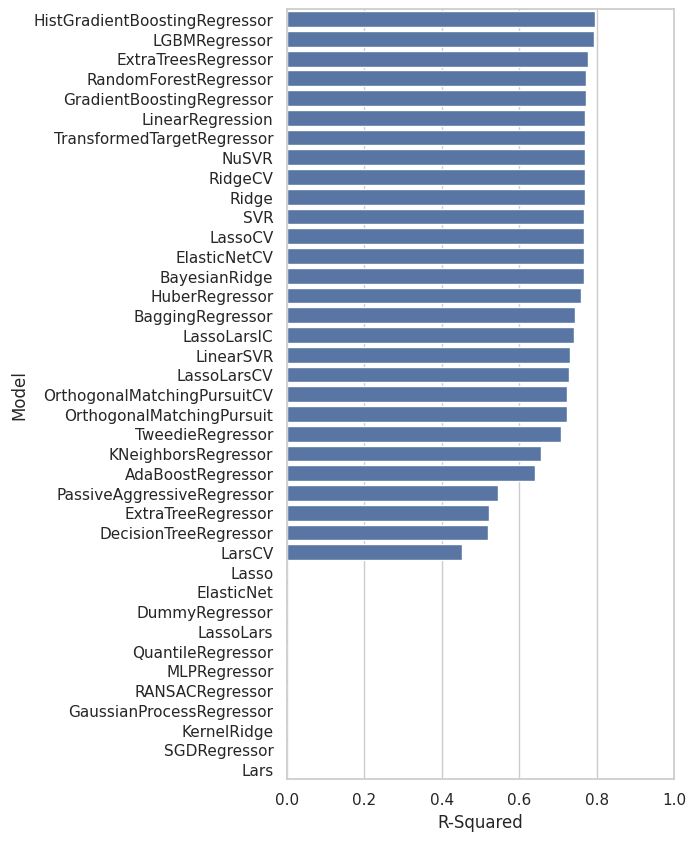

In [ ]:
# Bar plot of R-squared values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_1.index, x="R-Squared", data=predictions_1)
ax.set(xlim=(0, 1))

[(0.0, 10.0)]

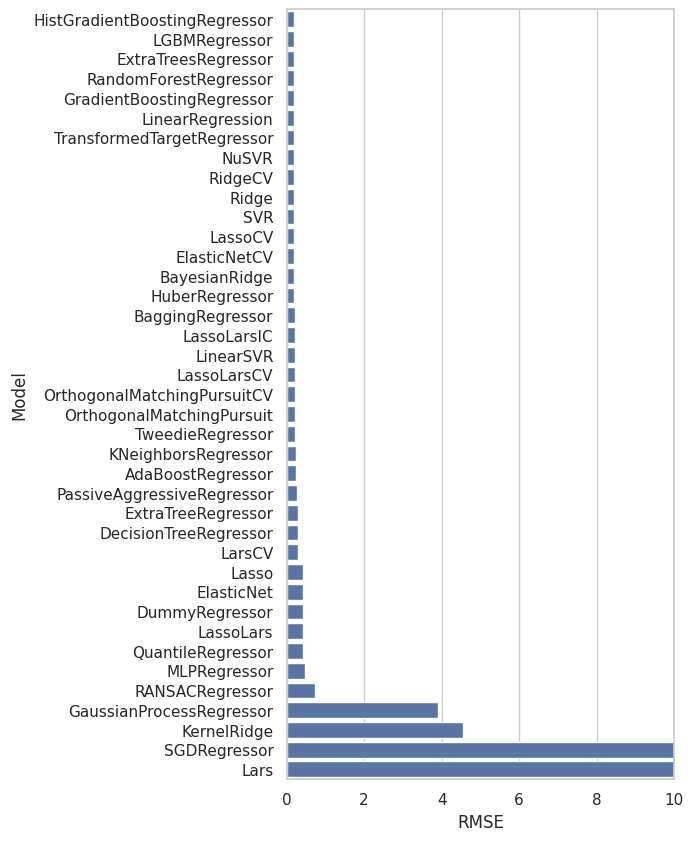

In [ ]:
# Bar plot of RMSE values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_1.index, x="RMSE", data=predictions_1)
ax.set(xlim=(0, 10))

[(0.0, 10.0)]

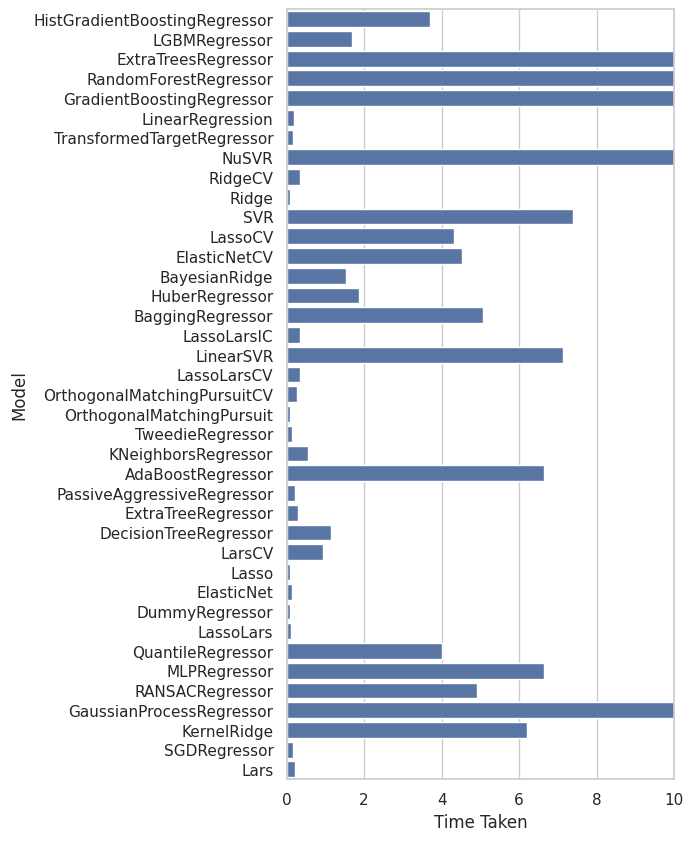

In [ ]:
# Bar plot of calculation time
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_1.index, x="Time Taken", data=predictions_1)
ax.set(xlim=(0, 10))

PaDEL

In [ ]:
# Defines and builds the lazyregressor
clf = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models_2, predictions_2 = clf.fit(X_train_2, X_test_2, Y_train_2, Y_test_2)

 98%|█████████▊| 41/42 [31:01<00:31, 31.96s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196542
[LightGBM] [Info] Number of data points in the train set: 5960, number of used features: 980
[LightGBM] [Info] Start training from score -4.540419


100%|██████████| 42/42 [31:19<00:00, 44.75s/it]


[(0.0, 1.0)]

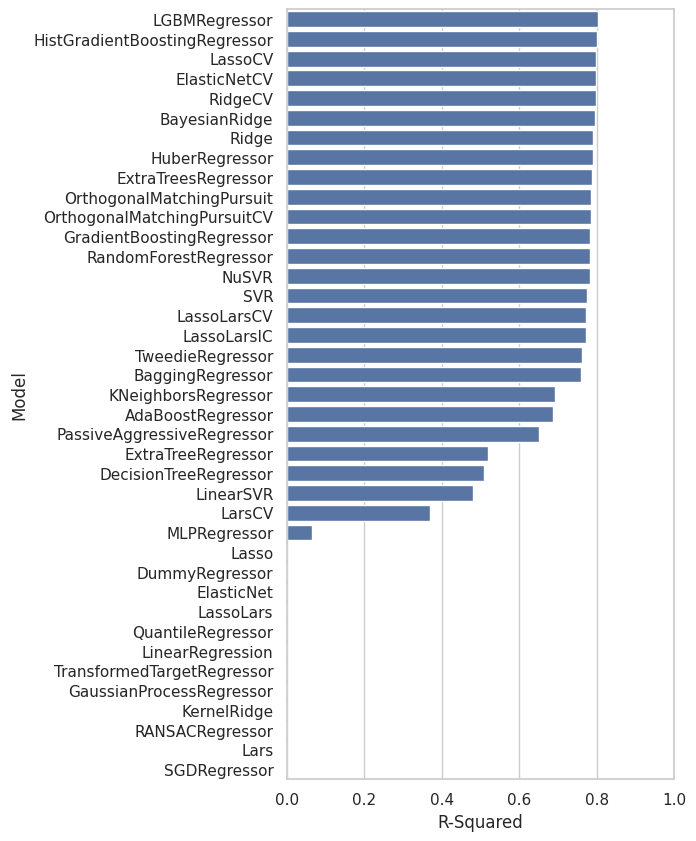

In [ ]:
# Bar plot of R-squared values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_2.index, x="R-Squared", data=predictions_2)
ax.set(xlim=(0, 1))

[(0.0, 10.0)]

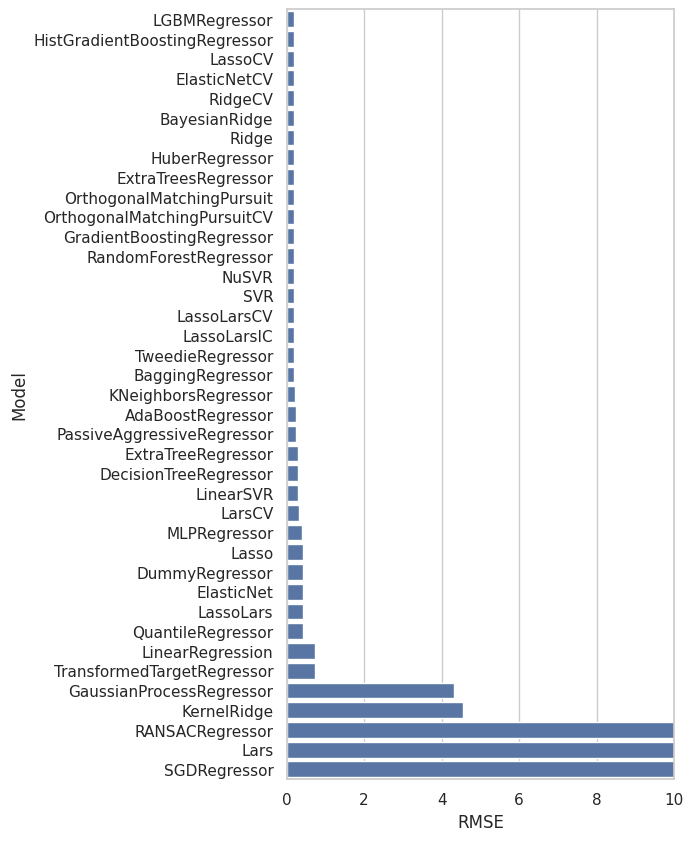

In [ ]:
# Bar plot of RMSE values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_2.index, x="RMSE", data=predictions_2)
ax.set(xlim=(0, 10))

[(0.0, 10.0)]

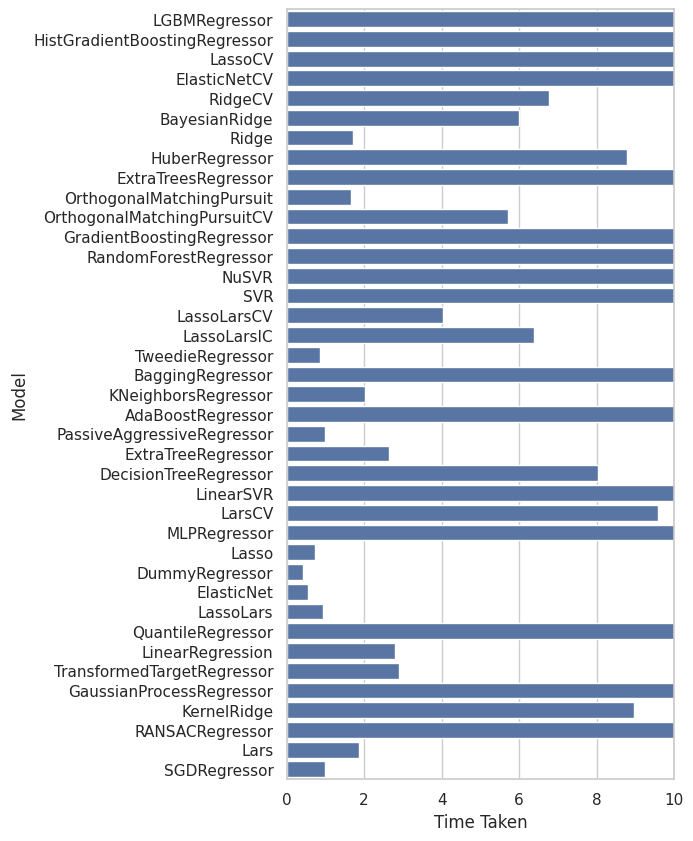

In [ ]:
# Bar plot of calculation time
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_2.index, x="Time Taken", data=predictions_2)
ax.set(xlim=(0, 10))

RDKit & PADEL

In [ ]:
# Defines and builds the lazyregressor
clf = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models_3, predictions_3 = clf.fit(X_train_3, X_test_3, Y_train_3, Y_test_3)

 98%|█████████▊| 41/42 [36:36<00:37, 37.58s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217825
[LightGBM] [Info] Number of data points in the train set: 5960, number of used features: 1149
[LightGBM] [Info] Start training from score -4.540419


100%|██████████| 42/42 [36:57<00:00, 52.80s/it]


[(0.0, 1.0)]

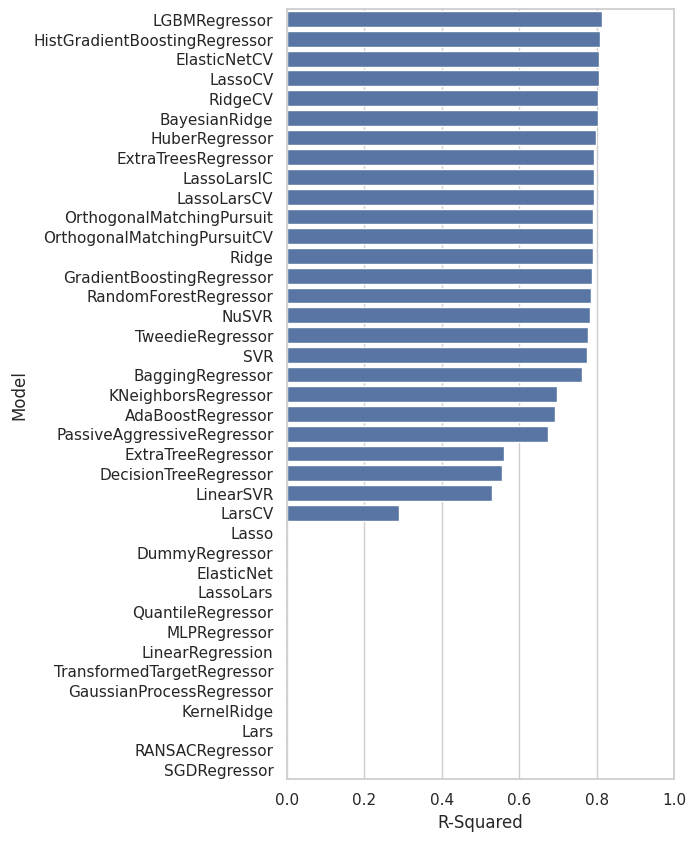

In [ ]:
# Bar plot of R-squared values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_3.index, x="R-Squared", data=predictions_3)
ax.set(xlim=(0, 1))

[(0.0, 10.0)]

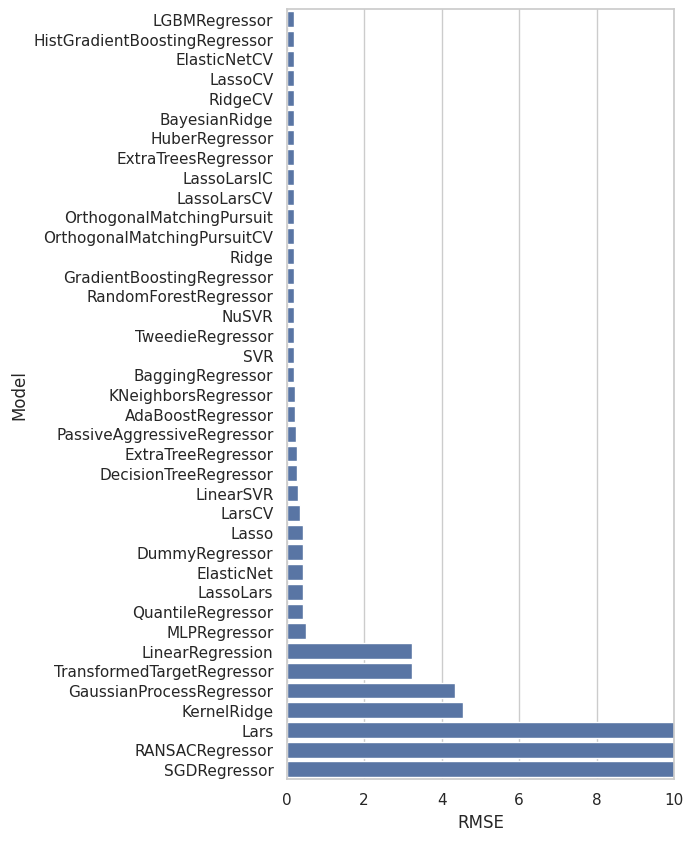

In [ ]:
# Bar plot of RMSE values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_3.index, x="RMSE", data=predictions_3)
ax.set(xlim=(0, 10))

[(0.0, 10.0)]

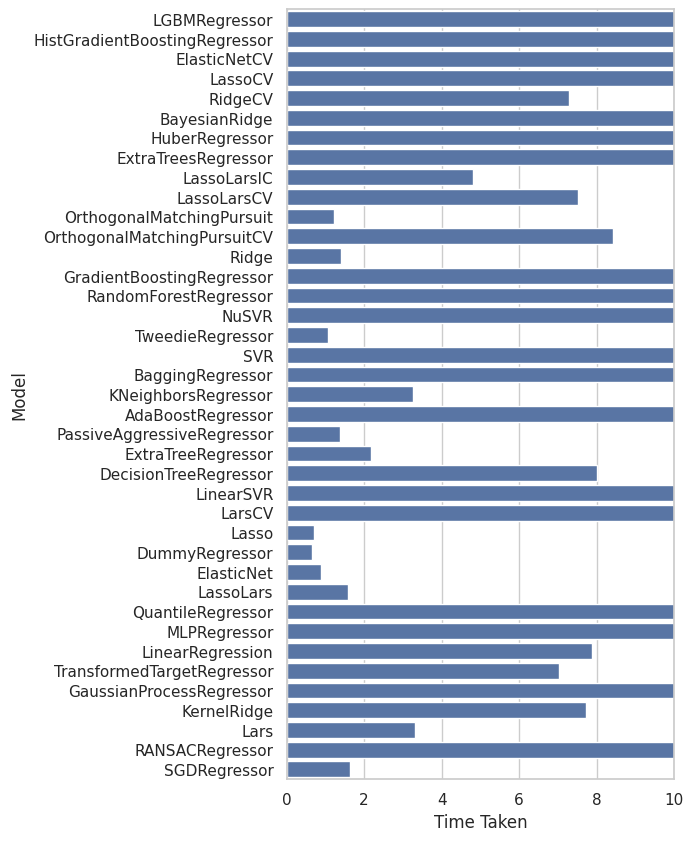

In [ ]:
# Bar plot of calculation time
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_3.index, x="Time Taken", data=predictions_3)
ax.set(xlim=(0, 10))

### Apply Regressors

In [ ]:
# Regression models
models_ml = {
    "KernelRidge": KernelRidge(),
    "TransformedTargetRegressor": TransformedTargetRegressor(),
    "LinearRegression": LinearRegression(),
    "Lars": Lars(),
    "LassoLarsIC": LassoLarsIC(),
    "GaussianProcessRegressor": GaussianProcessRegressor(),
    "MLPRegressor": MLPRegressor(),
    "RANSACRegressor": RANSACRegressor(),
    "PassiveAggressiveRegressor": PassiveAggressiveRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "GradientBoostingRegressor": GradientBoostingRegressor(),
    "BaggingRegressor": BaggingRegressor(),
    "OrthogonalMatchingPursuit": OrthogonalMatchingPursuit(),
    "LinearSVR": LinearSVR(),
    "SGDRegressor": SGDRegressor(),
    "LassoLarsCV": LassoLarsCV(),
    "LassoCV": LassoCV(),
    "LarsCV": LarsCV(),
    "ElasticNetCV": ElasticNetCV(),
    "Lasso": Lasso(),
    "LassoLars": Lasso(),
    "ElasticNet": ElasticNet(),
    "DummyRegressor": DummyRegressor(),
    "HistGradientBoostingRegressor": HistGradientBoostingRegressor(),
    "LGBMRegressor": LGBMRegressor(),
    "OrthogonalMatchingPursuitCV": OrthogonalMatchingPursuitCV(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(),
    "KNeighborsRegressor": KNeighborsRegressor(),
    "ExtraTreeRegressor": ExtraTreeRegressor(),
    "AdaBoostRegressor": AdaBoostRegressor(),
    "TweedieRegressor": TweedieRegressor(),
    "GammaRegressor": GammaRegressor(),
    "XGBRegressor": XGBRegressor(),
    "NuSVR": NuSVR(),
    "PoissonRegressor": PoissonRegressor(),
    "Ridge": Ridge(),
    "RidgeCV": RidgeCV(),
    "BayesianRidge": BayesianRidge(),
    "HuberRegressor": HuberRegressor(),
    "ExtraTreesRegressor": ExtraTreesRegressor()
}

RDKit

In [ ]:
print("{:>30} {:>30}".format("MODEL", "SCORE"))
for name, mdl in models_ml.items():
    try:
        kf = KFold(n_splits=5)
        score = cross_val_score(mdl, input_1, output_1, cv=kf, scoring='r2')
        show_values = [name, np.round(np.mean(score), 2)]
        print("{:>30} {:>30}".format(*show_values), np.round(score, 2))
    except Exception as e:
        print("{:>30} {:>30}".format(name, "error"))

                         MODEL                          SCORE
                   KernelRidge                           0.67 [0.64 0.75 0.72 0.65 0.6 ]
    TransformedTargetRegressor                         -18.12 [  0.65   0.76   0.73   0.66 -93.39]
              LinearRegression                         -18.12 [  0.65   0.76   0.73   0.66 -93.39]
                          Lars        -1.9603289465412653e+30 [-1.81357692e+29 -3.42366930e+25 -1.11852017e+24 -1.28072630e+25
 -9.62023888e+30]
                   LassoLarsIC                           0.66 [0.65 0.69 0.72 0.6  0.62]
      GaussianProcessRegressor                           -2.6 [-1.88 -0.85 -0.85 -1.71 -7.73]
                  MLPRegressor                           0.67 [0.62 0.78 0.74 0.57 0.64]
               RANSACRegressor                        -114.65 [-9.0000e-02  5.1000e-01  7.0000e-02 -6.0000e-01 -5.7316e+02]
    PassiveAggressiveRegressor                           0.63 [0.55 0.72 0.7  0.63 0.55]
         DecisionTree

PaDEL

In [ ]:
print("{:>30} {:>30}".format("MODEL", "SCORE"))
for name, mdl in models_ml.items():
    try:
        kf = KFold(n_splits=5)
        score = cross_val_score(mdl, input_2, output_2, cv=kf, scoring='r2')
        show_values = [name, np.round(np.mean(score), 2)]
        print("{:>30} {:>30}".format(*show_values), np.round(score, 2))
    except Exception as e:
        print("{:>30} {:>30}".format(name, "error"))

                         MODEL                          SCORE
                   KernelRidge                           0.73 [0.75 0.79 0.77 0.71 0.65]
    TransformedTargetRegressor                      -27689.35 [-1.3836594e+05  5.5000000e-01 -1.6000000e+00 -6.8980000e+01
 -1.0800000e+01]
              LinearRegression                      -27689.35 [-1.3836594e+05  5.5000000e-01 -1.6000000e+00 -6.8980000e+01
 -1.0800000e+01]
                          Lars         -5.193267718354355e+31 [-2.88299496e+09 -1.58019334e+07 -1.82665374e+31 -1.92490316e+31
 -2.22147817e+32]
                   LassoLarsIC                           0.73 [0.73 0.77 0.73 0.7  0.72]
      GaussianProcessRegressor                         -20.29 [-24.37 -11.82 -12.92 -24.   -28.35]
                  MLPRegressor                           0.68 [0.8  0.61 0.64 0.66 0.69]
               RANSACRegressor                     -218264.53 [-1.06969961e+06 -2.53560000e+02 -1.29000000e+00 -8.18310000e+03
 -1.31851000e+04]
  

RDKit & PaDEL

In [ ]:
print("{:>30} {:>30}".format("MODEL", "SCORE"))
for name, mdl in models_ml.items():
    try:
        kf = KFold(n_splits=5)
        score = cross_val_score(mdl, input_3, output_3, cv=kf, scoring='r2')
        show_values = [name, np.round(np.mean(score), 2)]
        print("{:>30} {:>30}".format(*show_values), np.round(score, 2))
    except Exception as e:
        print("{:>30} {:>30}".format(name, "error"))

                         MODEL                          SCORE
                   KernelRidge                           0.73 [0.72 0.79 0.78 0.72 0.64]
    TransformedTargetRegressor                       -10320.8 [-4.974905e+04  1.900000e-01 -7.400000e+00 -1.000000e-01 -1.847620e+03]
              LinearRegression                       -10320.8 [-4.974905e+04  1.900000e-01 -7.400000e+00 -1.000000e-01 -1.847620e+03]
                          Lars        -1.1933171934362337e+23 [-1.40629110e+05 -1.09746890e+05 -5.46389526e+08 -5.96584809e+23
 -7.37878312e+19]
                   LassoLarsIC                           0.74 [0.74 0.79 0.76 0.71 0.72]
      GaussianProcessRegressor                         -29.57 [-31.15 -19.89 -21.53 -35.95 -39.32]
                  MLPRegressor                           0.68 [0.72 0.69 0.64 0.66 0.67]
               RANSACRegressor                    -1668463.37 [-1383551.88   -12333.72   -54014.45   -22553.14 -6869863.63]
    PassiveAggressiveRegressor     